# Q-Learning in Reinforcement Learning

Q-Learning is most primitive, but big part of algorithms to learn reinforcement learning.

In order to understand how it works, first let's consider the expected rewards as follows.

$$ R = \sum_{t=0}^{\infty} {\gamma^t r_t} $$

where $r_t$ is a reward value obtained at $t$ and $\gamma$ is discount.

For instance, when you try to grab an object, you will do the following 3 actions :

- action #1 : Stretch your arm ($t=0$)<br>
  Getting reward 0.
- action #2 : Open your hand ($t=1$)<br>
  Getting reward 0.
- action #3 : Grab an object ($t=2$)<br>
  Getting reward 10.

In this case, you will get a reward value 10 on action #3 ($t=2$), however the action #1 ($t=0$) is obviously contributing to the final rewards. Hence, we consider that the action #1 will have the following expected cumulative reward.<br>
Here we assume $\gamma$ is 0.99.

$$ R_{t=0} = 0 + 0.99 \times 0 + 0.99^2 \times 10 = 9.801 $$

Same as above, $R_{t=1} = 9.9, R_{t=2} = 10$.

Q-value is based on this idea of expected cumulative reward. Depending on each state (observation), the each action will have the corresponding expected reward.<br>
In above example, if you see an object in front of you (i.e, the **state** of "you see an object"), the **action** "stretching your arm" will have high value of expected reward. However, if you cannot see an object anywhere, the action "stretching your arm" will have low value of expected reward.

Q-value of each corresponding state and action is denoted as $Q(s, a)$. Suppose both action and state has 1 dimension of discrete values, $Q(s, a)$ will be written as a table (called Q-Table) as follows.<br>
If the state is s2, the optimal action to pick up will be action a2. If s3, the optimal action will be action a4.

![Q-Table](assets/q-table.png?raw=true)

In practice, both action space and observation space may have more than 1 dimension. For instance, in CartPole example (below example), the returned state (observation) has 4 elements of float values, i.e, 4 dimensions. (See [readme.md](https://github.com/tsmatz/reinforcement-learning-tutorials/) for CartPole.) Then Q-Table will be the combination of 1 dimension (action space) and 4 dimension (observation space).

In Q-Learning, we optimize this table by the following iterative updates ($t=0,1,2,\ldots$).<br>
In the following equation, $ Q_t(s_t,a_t) $ is current Q-value and $ Q_{t+1}(s_t,a_t) $ is the updated Q-value.

$$ Q_{t+1}(s_t,a_t) = Q_t(s_t,a_t) + \alpha \left( r_t + \gamma \max_a{Q_t(s_{t+1},a)} - Q_t(s_t,a_t) \right) $$

where $\alpha$ is learning rate.

This equation means that :

- Suppose, you executed an action $a_t$ on state $s_t$, and as a result, you got reward $r_t$ and the state has changed to $s_{t+1}$.
- The optimal next action will satisfy $a_{t+1}=\max_{a}{Q(s_{t+1},a)}$.<br>
  By taking this optimal action, you will then get the expected reward : $r_t + \gamma \max_{a}{Q(s_{t+1},a)}$.
- Compare this optimal q-value with current q-value $Q(s_t,a_t)$ in q-table. Then update this current value $Q(s_t,a_t)$ by learning rate $\alpha$.<br>
  This will result into above equation.

Now let's build this Python example with CartPole environment. (See [readme.md](https://github.com/tsmatz/reinforcement-learning-tutorials/) about CartPole.)

*(back to [index](https://github.com/tsmatz/reinforcement-learning-tutorials/))*

First, please install the required packages and import these modules.

In [ ]:
!pip install numpy gym matplotlib

In [1]:
import gym
import numpy as np

CartPole has 4 elements of continuos (float) observation space. In order for applying primitive Q-Learning, we should convert continuous state to discrete state (i.e, **discretize**).<br>
In this example, we will convert Tuple(Box, Box, Box, Box) into Tuple(Discrete(20), Discrete(20), Discrete(20), Discrete(20)) - which converts float value to the bin of value for each segment.

![discretize](assets/discretize.png?raw=true)

In [2]:
import math

env = gym.make("CartPole-v1")

new_observation_shape = (20, 20, 20, 20)

bins = []
for i in range(4):
    item = np.linspace(
        env.observation_space.low[i] if (i == 0) or (i == 2) else -4,
        env.observation_space.high[i] if (i == 0) or (i == 2) else 4,
        num=new_observation_shape[i],
        endpoint=False)
    item = np.delete(item, 0)
    bins.append(item)
    print(bins[i])

# define function to convert to discrete state
def get_discrete_state(s):
    new_s = []
    for i in range(4):
        new_s.append(np.digitize(s[i], bins[i]))
    return new_s

[-4.32000017 -3.84000015 -3.36000013 -2.88000011 -2.4000001  -1.92000008
 -1.44000006 -0.96000004 -0.48000002  0.          0.48000002  0.96000004
  1.44000006  1.92000008  2.4000001   2.88000011  3.36000013  3.84000015
  4.32000017]
[-3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6
  2.   2.4  2.8  3.2  3.6]
[-0.37699113 -0.33510323 -0.29321532 -0.25132742 -0.20943952 -0.16755161
 -0.12566371 -0.08377581 -0.0418879   0.          0.0418879   0.08377581
  0.12566371  0.16755161  0.20943952  0.25132742  0.29321532  0.33510323
  0.37699113]
[-3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6
  2.   2.4  2.8  3.2  3.6]


Now we generate Q-Table $Q(s,a)$ and initialize all values by 0. (Here it's 5 dimensional table.)

In [3]:
q_table = np.zeros(new_observation_shape + (env.action_space.n,))
q_table.shape

(20, 20, 20, 20, 2)

Now, update Q-Table with above Q-Learning algorithm.

However, in the beginning, Q-Table was initialized all by zeros (not optimized at all) and will always pick up wrong actions. Therefore, the action is randomly picked up to explore in the first stage, and when it grows to learn, it then picks up the optimal actions with Q-Table gradually using the following coefficient parameter $\epsilon$ to control. (This exploration algorithm is called **Epsilon-Greedy**.)

In [4]:
gamma = 0.99
alpha = 0.1
epsilon = 1
epsilon_decay = epsilon / 4000

# pick up action from q-table with greedy exploration
def pick_sample(s, episode_num):
    # get optimal action,
    # but with greedy exploration (to prevent picking up same values in the first stage)
    if np.random.random() > epsilon:
        a = np.argmax(q_table[tuple(s)])
    else:
        a = np.random.randint(0, env.action_space.n)
    return a

env = gym.make("CartPole-v1")
reward_records = []
for i in range(6000):
    # Run episode till done
    done = False
    total_reward = 0
    s, _ = env.reset()
    s_dis = get_discrete_state(s)
    while not done:
        a = pick_sample(s_dis, i)
        s, r, term, trunc, _ = env.step(a)
        done = term or trunc
        s_dis_next = get_discrete_state(s)

        # Update Q-Table
        maxQ = np.max(q_table[tuple(s_dis_next)])
        q_table[tuple(s_dis)][a] += alpha * (r + gamma * maxQ - q_table[tuple(s_dis)][a])

        s_dis = s_dis_next
        total_reward += r

    # Update epsilon for each episode
    if epsilon - epsilon_decay >= 0:
        epsilon -= epsilon_decay

    # Record total rewards in episode (max 500)
    print("Run episode{} with rewards {}".format(i, total_reward), end="\r")
    reward_records.append(total_reward)

print("\nDone")
env.close()

/home/tsmatsuz/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Run episode5999 with rewards 500.0
Done


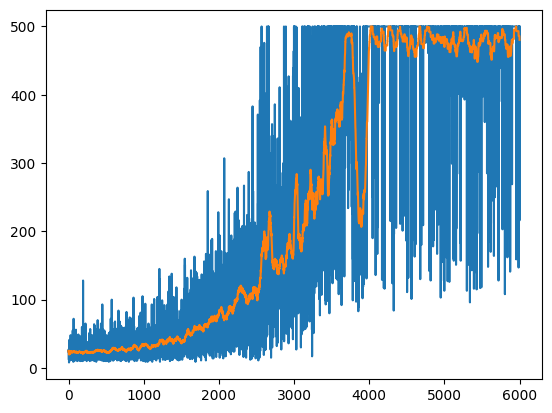

In [5]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
# Plot
plt.plot(reward_records)
plt.plot(average_reward)

As you can see above, this method won't work in large continuous and stochastic spaces (e.g, continuos action space), since this method will need so many discrete mesh for solving problems.<br>
In the next tutorial, we'll learn the idea of policy gradient methods, which will take effects in such a case.